# Using PyTorch for simple regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/2.pytorch-nn-training-cars.ipynb)

By [Terence Parr](https://explained.ai).

Once we can implement our own gradient descent using pytorch autograd and matrix algebra, it's time to graduate to using pytorch's built-in neural network module and the built-in optimizers (e.g., Adam). Next, we observe how a sequence of two linear models is effectively the same as a single linear model. After we add a nonlinearity, we see more sophisticated curve fitting. Then we'll see how a sequence of multiple linear units plus nonlinearities affects predictions. Finally, we'll see what happens if we give a model too much power: the regression curve can easily overfit the training data.

## Support code

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def carshow(m, b, X, y, xcol='WGT', file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel(f"{xcol} (Standardized)")
    else:
        ax.set_xlabel(xcol)
    ax.set_ylabel("MPG")

    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
    
    plt.show()

def mshow(model, X, y, xcol='WGT', file=None):
    "Plot X[xcol] vs MPG (y) and show model predictions for each x"
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel(f"{xcol} (Standardized)")
    else:
        ax.set_xlabel(xcol)
    ax.set_ylabel("MPG")
    ax.set_title("Model predictions")
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
    plt.show()

## Load simple data set

In [3]:
df_cars = pd.read_csv("data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [4]:
# normalize the data again; regression will be WGT -> MPG
n = len(df_cars)
X = torch.tensor(df_cars.WGT).float().reshape(n,1)
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

## Pytorch built-in linear model

We've been doing our own matrix arithmetic to implement a linear model, which is really just a linear layer with one neuron in a deep learning network.  Now, let's use PyTorch's built-in linear layer component.  We can also avoid updating the model parameters manually, which can get very complicated, using a built-in optimizer. Let's copy the PyTorch training loop from the previous notebook and make the necessary changes. Side-by-side, here are the changes:

<img src="images/LA_to_nn.png" width="800">

The `nn.Linear` object represents a single linear layer and we must specify the number of features for each instance coming in and the number of neurons in the layer. A typical linear regression model is

```python
model = nn.Linear(in_features=1, out_features=1)
```

Graphically, that looks like:
 
<img src="images/nn.1-layer-regr.png" width="200">

One of the key elements here is telling the optimizer what the model parameters are. The `parameters()` method of the standard neural network layers returns a list of tensors, which the optimizer adjusts during training:

In [5]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value
list(model.parameters())

[Parameter containing:
 tensor([[0.3465]], requires_grad=True),
 Parameter containing:
 tensor([-0.5558], requires_grad=True)]

Here is the full training loop and visualization calls:

Epoch   0 MSE loss      596.075 MAE    22.96
Epoch  10 MSE loss      193.959 MAE    13.17
Epoch  20 MSE loss       42.834 MAE     5.28
Epoch  30 MSE loss       20.257 MAE     3.49
Epoch  40 MSE loss       24.363 MAE     4.04
Epoch  50 MSE loss       21.309 MAE     3.68
Epoch  60 MSE loss       18.802 MAE     3.30
Epoch  70 MSE loss       18.873 MAE     3.28
Epoch  80 MSE loss       18.803 MAE     3.27
Epoch  90 MSE loss       18.679 MAE     3.27
Epoch 100 MSE loss       18.689 MAE     3.29
LAST      MSE loss       18.689 MAE     3.29


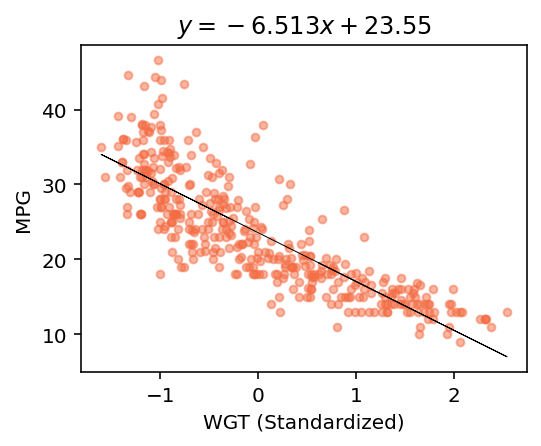

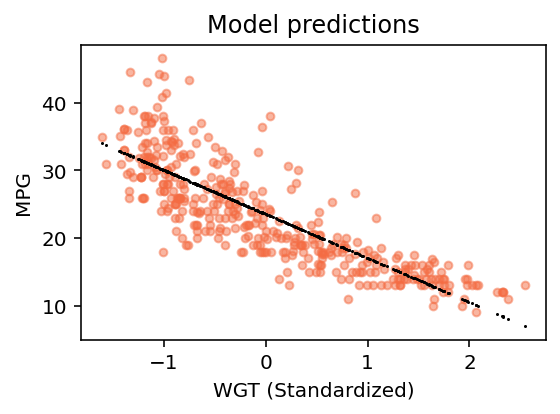

In [8]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=100
for epoch in range(nepochs+1):
    with tsensor.clarify(): # this visualizes any errors we get but you can remove this if you want
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG) # plot line with computed m, b
mshow(model, X=X, y=df_cars.MPG)  # make predictions using model for X

## Factor out a training method

It is good programming practice to factor out code into a function that we use a lot, which is the case here for our training loop:

In [10]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

With all of those details hidden in a `train()` function, we get a very clear picture of the architecture of the model and the training. It's a simple matter of creating the appropriate model, training it, and then displaying the predictions:

Epoch    0 MSE loss      560.445 MAE    22.49
Epoch   10 MSE loss      183.560 MAE    12.70
Epoch   20 MSE loss       37.552 MAE     4.86
Epoch   30 MSE loss       20.281 MAE     3.52
Epoch   40 MSE loss       24.820 MAE     4.06
Epoch   50 MSE loss       20.914 MAE     3.64
Epoch   60 MSE loss       18.695 MAE     3.29
Epoch   70 MSE loss       18.903 MAE     3.28
Epoch   80 MSE loss       18.787 MAE     3.26
Epoch   90 MSE loss       18.679 MAE     3.28
Epoch  100 MSE loss       18.691 MAE     3.29
LAST       MSE loss       18.691 MAE     3.29


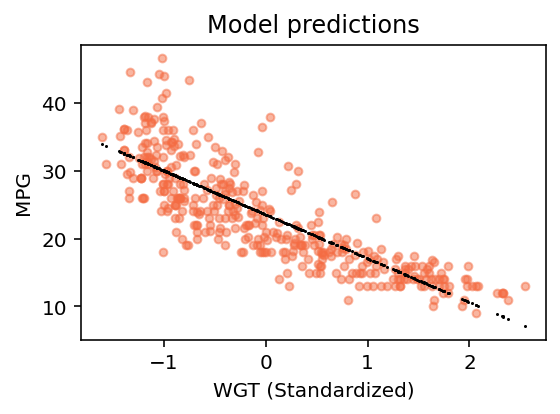

In [11]:
model = nn.Linear(1, 1)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

### Without nonlinearity

If we send the output of a linear model into another linear model, we get just another linear model. We have to add a nonlinearity such as a rectified linear unit (ReLU) or a sigmoid to get more predictive power. To demonstrate that, let's build a two layer neural network where each layer has a single neuron. Graphically, that looks like:
 
<img src="images/nn.2-layer-regr-no-nonlin.png" width="300">

Epoch    0 MSE loss      637.139 MAE    24.03
Epoch   10 MSE loss       88.747 MAE     7.93
Epoch   20 MSE loss       25.654 MAE     3.57
Epoch   30 MSE loss       20.558 MAE     3.42
Epoch   40 MSE loss       20.055 MAE     3.29
Epoch   50 MSE loss       18.782 MAE     3.29
Epoch   60 MSE loss       18.772 MAE     3.31
Epoch   70 MSE loss       18.677 MAE     3.28
Epoch   80 MSE loss       18.711 MAE     3.26
Epoch   90 MSE loss       18.680 MAE     3.28
Epoch  100 MSE loss       18.677 MAE     3.28
LAST       MSE loss       18.677 MAE     3.28


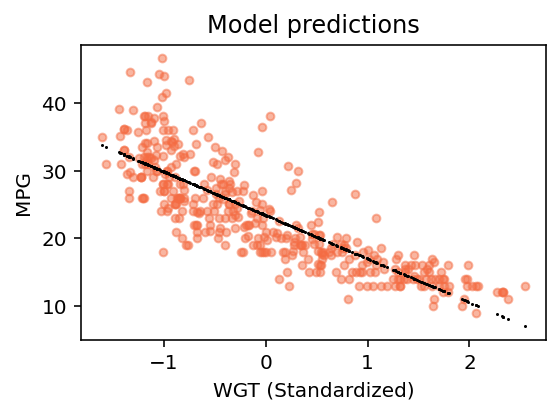

In [12]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 feature, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="2linear")

As you can see, the predictions of the model still look like a best fit **line** through the training data.

### With ReLU nonlinearity

If we stick a ReLU between the output of the first layer and the input of the second layer, all of a sudden we get a piecewise linear regression:

<img src="images/nn.2-layer-regr-relu.png" width="350">

Epoch    0 MSE loss      630.864 MAE    23.89
Epoch   10 MSE loss      122.794 MAE     9.36
Epoch   20 MSE loss       49.040 MAE     5.36
Epoch   30 MSE loss       21.600 MAE     3.73
Epoch   40 MSE loss       23.652 MAE     4.01
Epoch   50 MSE loss       22.879 MAE     3.72
Epoch   60 MSE loss       20.070 MAE     3.50
Epoch   70 MSE loss       19.443 MAE     3.42
Epoch   80 MSE loss       18.664 MAE     3.29
Epoch   90 MSE loss       18.245 MAE     3.22
Epoch  100 MSE loss       18.039 MAE     3.18
LAST       MSE loss       18.039 MAE     3.18


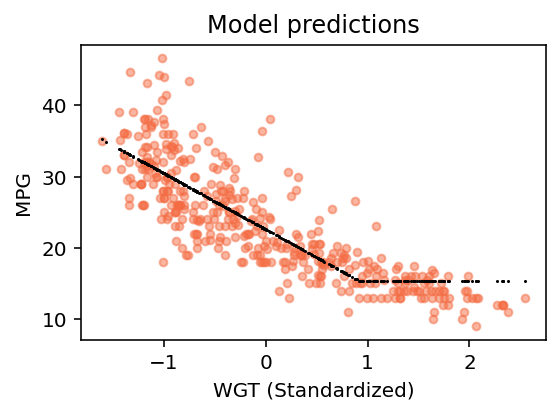

In [18]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 feature, spit out 1 values
    nn.ReLU(),       # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linRlin")

#### Exercise

Run that cell many times and observe where the kink in the line is; it should bounce around the WGT=1 position. Why do we get slightly different models?

<details>
<summary>Solution</summary>
    We are initializing the model parameters randomly and so training starts at different locations. Our final model position in parameter space depends on our starting location because we are running for a finite number of iterations. In principle, if we ran it for a very long time we would always end up in the same spot because our model is so simple.
</details>

## Layers with multiple neurons

Each linear model (neuron) is fairly weak because it can only predict a single line.  Adding multiple layers allows us to draw piecewise linear curves as we just saw.  We can also stack multiple neurons at each layer. Because we are initializing the weights of every neuron randomly and because the subsequent layer uses the output of the first layer as different features, each neuron in the layer can converge on a different linear model during training. Graphically, it looks like this if we stack five neurons in the first layer but keep everything else the same:

<img src="images/nn.2-layer-5-neuron-regr-relu.png" width="350">

It's a good idea to visualize the dimensions of the matrix and vector operations. TensorSensor can help you out here:

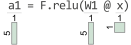

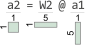

In [19]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor # https://github.com/parrt/tensor-sensor

W1 = torch.rand(5,1)
W2 = torch.rand(1,5)
x = torch.rand(1,1)
with tsensor.explain():
    a1 = F.relu(W1 @ x)
    a2 = W2 @ a1

Using the prebuilt linear layer, we increase the number of output features for the first layer to 5 and then the second layer has five input features.

Epoch    0 MSE loss      633.415 MAE    23.92
Epoch   10 MSE loss       72.112 MAE     7.45
Epoch   20 MSE loss       20.850 MAE     3.58
Epoch   30 MSE loss       20.176 MAE     3.48
Epoch   40 MSE loss       18.484 MAE     3.13
Epoch   50 MSE loss       18.177 MAE     3.11
Epoch   60 MSE loss       17.714 MAE     3.14
Epoch   70 MSE loss       17.660 MAE     3.14
Epoch   80 MSE loss       17.601 MAE     3.13
Epoch   90 MSE loss       17.575 MAE     3.11
Epoch  100 MSE loss       17.555 MAE     3.10
LAST       MSE loss       17.555 MAE     3.10


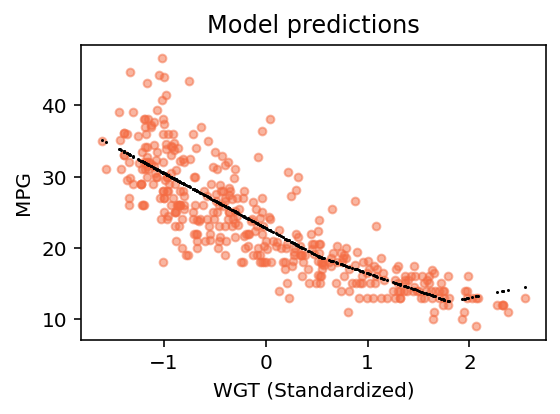

In [22]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin")

#### Exercise

Run that cell many times and observe where the kinks are in the line and how many there are.  How would you compare the performance of this model, at its best, to the previous model?

<details>
<summary>Solution</summary>
This model often gets a similar two-line solution just like the previous solution, but it often gets three or four line segments that seem to fit the data better.
</details>

#### Exercise

Create a three-layer regression network that looks like the following.

<img src="images/nn.3-layer-regr-relu.png" width="450">

Hint: just add another nonlinearity and a linear layer. The trick is to get the number of input and output features right. Does your solution get a smoother piecewise-linear solution? Is it worth the extra complexity and training time?

<details>
<summary>Solution</summary>

<pre>
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=.01, nepochs=500)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin2")
</pre>

</details>


Here is what the matrix algebra inside the model looks like:

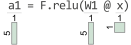

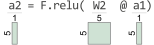

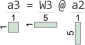

In [23]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor # https://github.com/parrt/tensor-sensor

W1 = torch.rand(5,1)
W2 = torch.rand(5,5)
W3 = torch.rand(1,5)
x = torch.rand(1,1)
with tsensor.explain() as e:
    a1 = F.relu(W1 @ x)
    a2 = F.relu(W2 @ a1)
    a3 = W3 @ a2

## Using the logistic function (sigmoid) nonlinearity instead of ReLU

Another nonlinearity we can use to glue layers together is the logistic function. It's slower to train but gives us curved lines through the data. Let's replace the rectified linear unit and see what the model predictions look like.

Epoch    0 MSE loss      646.288 MAE    24.15
Epoch  100 MSE loss      100.178 MAE     7.71
Epoch  200 MSE loss       34.614 MAE     4.45
Epoch  300 MSE loss       23.140 MAE     3.53
Epoch  400 MSE loss       19.811 MAE     3.26
Epoch  500 MSE loss       18.765 MAE     3.18
Epoch  600 MSE loss       18.356 MAE     3.15
Epoch  700 MSE loss       18.169 MAE     3.14
Epoch  800 MSE loss       18.067 MAE     3.14
Epoch  900 MSE loss       18.001 MAE     3.13
Epoch 1000 MSE loss       17.949 MAE     3.13
LAST       MSE loss       17.949 MAE     3.13


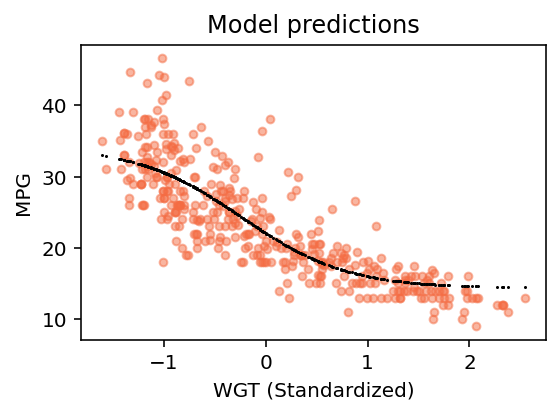

In [24]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=0.1, nepochs=1000)

mshow(model, X=X, y=df_cars.MPG, file='linSlin')

That's a really nice curve that fits the data very well.

#### Exercise

Change the learning rate from 0.1 to 2 and retrain the model multiple times. What do you observe?
<details>
<summary>Solution</summary>
   Sometimes we get a completely flat line at about y mean. Training is probably bouncing the model parameters back and forth across the valley walls and not able to descend into a minimum.
</details>

#### Exercise

Change the learning rate to 0.01 and retrain the model multiple times. What do you observe?

<details>
<summary>Solution</summary>
   The learning rate is too small and we do not converge fast enough for the thousand iterations to reach a minimum.
</details>

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      612.792 MAE    23.49
Epoch  100 MSE loss       17.196 MAE     3.04
Epoch  200 MSE loss       17.105 MAE     3.04
Epoch  300 MSE loss       17.006 MAE     3.04
Epoch  400 MSE loss       16.896 MAE     3.03
Epoch  500 MSE loss       16.782 MAE     3.02
Epoch  600 MSE loss       16.694 MAE     3.02
Epoch  700 MSE loss       16.649 MAE     3.01
Epoch  800 MSE loss       16.581 MAE     3.00
Epoch  900 MSE loss       16.564 MAE     3.00
Epoch 1000 MSE loss       16.543 MAE     2.99
LAST       MSE loss       16.543 MAE     2.99


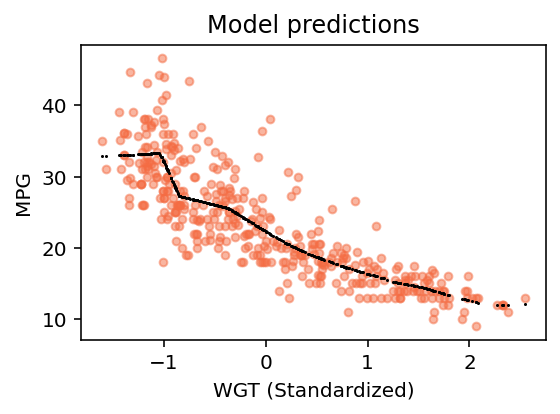

In [25]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1000)

mshow(model, X=X, y=df_cars.MPG, file="lin1kRlin")

#### Exercise

Change the nonlinearity from a rectified linear unit to a sigmoid, keeping the 1000-neuron layer. Does this overfit like the ReLU?

<details>
<summary>Solution</summary>

<pre>
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Sigmoid(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1000)

mshow(model, X=X, y=df_cars.MPG)
</pre>
    
<br><br>
    This model does not seem to overfit. This highlights the fact that different architectures with the exact same number of iterations and learning rate can give you very different models. Using the sigmoid is slower but seems to resist kinks in the curve that chase noise.

</details>
